In [41]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/vanshbansal1505/ICG-Summer-Program-2021-DS/main/Assignment-1/data/train.csv')
df.drop("PassengerId", axis=1,inplace=True)
last = df.pop('Survived')
df.insert(6,'Survived',last)
df["Age"].fillna(df["Age"].median(skipna=True), inplace=True)
df.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,2.309677,29.404839,0.538710,0.382258,31.746982,0.393548
std,0.833993,12.810898,1.086018,0.792131,45.907139,0.488931
min,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.925000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.750000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,30.548950,1.000000
max,3.000000,71.000000,8.000000,5.000000,512.329200,1.000000


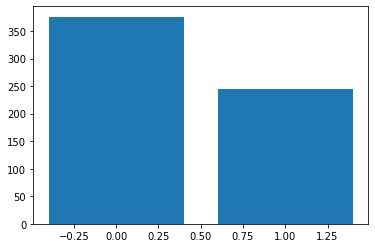

0    376
1    244
Name: Survived, dtype: int64

In [43]:
counts = df["Survived"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
df['Survived'].value_counts()

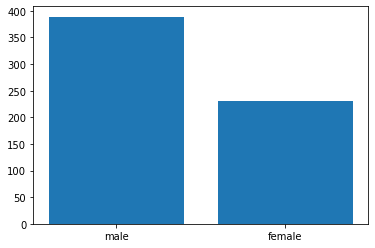

male      389
female    231
Name: Sex, dtype: int64

In [44]:
counts = df["Sex"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
df['Sex'].value_counts()

,Sex,Survived
0,female,0.748918
1,male,0.182519


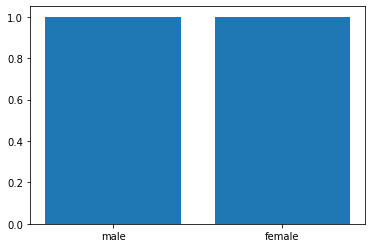

In [45]:
plt.bar(x='Sex',height='Survived',data=df)
df.groupby('Sex',as_index=False).Survived.mean()

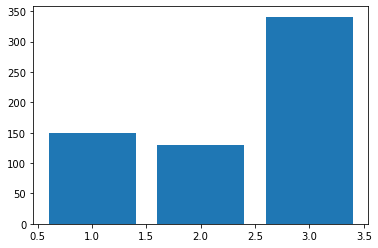

3    341
1    149
2    130
Name: Pclass, dtype: int64

In [46]:
counts = df["Pclass"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
df['Pclass'].value_counts()

,Pclass,Survived
0,1,0.597315
1,2,0.515385
2,3,0.258065


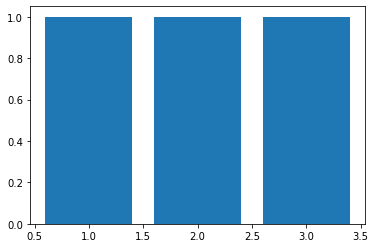

In [47]:
plt.bar(x='Pclass',height='Survived',data=df)
df.groupby('Pclass',as_index=False).Survived.mean()

In [49]:
def train_test_split(df, test_size):
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

In [50]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=150)

In [51]:
data = train_df.values

In [52]:
def purity(data):
    survived_column = data[:, -1]
    unique_classes = np.unique(survived_column)
    if len(unique_classes) == 1:
        return True
    else:
        return False

In [53]:
def classify_data(data):
    survived_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(survived_column, return_counts=True)
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    return classification

In [54]:
def get_potential_splits(data):
    splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):
        values = data[:, column_index]
        unique_values = np.unique(values)
        splits[column_index] = unique_values
    return splits

In [55]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value] 
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [56]:
def calculate_entropy(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

In [57]:
def calculate_overall_entropy(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below)/n
    p_data_above = len(data_above)/n
    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    return overall_entropy

In [58]:
def determine_best_split(data, potential_splits):
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    return best_split_column, best_split_value

In [59]:
def determine_type_of_feature(df):    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]
            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    return feature_types

In [60]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    if (purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification
    else:    
        counter += 1
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
        else:
            question = "{} = {}".format(feature_name, split_value)
        sub_tree = {question: []}
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [61]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")    
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [62]:
def calculate_accuracy(df, tree):
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["Survived"]
    accuracy = df["classification_correct"].mean()
    return accuracy

In [63]:
my_tree = decision_tree_algorithm(train_df, max_depth=7)
accuracy = calculate_accuracy(test_df, my_tree)
accuracy

0.7733333333333333

In [64]:
df_test = pd.read_csv('https://raw.githubusercontent.com/vanshbansal1505/ICG-Summer-Program-2021-DS/main/Assignment-2/data/test.csv')

In [65]:
df_test.drop("PassengerId", axis=1, inplace=True)
l = df_test.pop('Survived')
df_test.insert(6, 'Survived', l)
df_test.isnull().sum()

Pclass       0
Sex          0
Age         46
SibSp        0
Parch        0
Fare         0
Survived     0
dtype: int64

In [66]:
data_test = df_test.values
acc = calculate_accuracy(df_test, my_tree)
print("Accuracy :",acc)

Accuracy : 0.8007380073800738
